In [1]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 📁 데이터 불러오기
df = pd.read_parquet('prepro_data.parquet')
df1 = df[df['호선'] == 2].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df1[col] = df1[col].astype('category')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15187582 entries, 0 to 15653609
Data columns (total 25 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        int64         
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   int64         
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        int32         
 18  월         int32         
 19  일         int32         
 20  시         int32         
 21  요일        int32         
 22  주말        int32         
 23  공휴일       int32         
 24  일사량_측정여부  int32         
dtypes: category(2), datetime64[ns](1), float32(11), int32(9), int64(2)
memory u

In [3]:
# 시 (0~23 기준)
df1['시_sin'] = np.sin(2 * np.pi * df1['시'] / 24)
df1['시_cos'] = np.cos(2 * np.pi * df1['시'] / 24)

# 요일 (0~6 기준, 월~일)
df1['요일_sin'] = np.sin(2 * np.pi * df1['요일'] / 7)
df1['요일_cos'] = np.cos(2 * np.pi * df1['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df1.select_dtypes(include=['float64']).columns
df1[float_cols] = df1[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df1.select_dtypes(include=['int64']).columns
df1[int_cols] = df1[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df1.select_dtypes(include=['object']).columns
df1[obj_cols] = df1[obj_cols].astype('category')    
    
df1 = df1.drop(['시', '요일'], axis=1)
df1.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df1.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1868722 entries, 950460 to 12006245
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: category

In [4]:
# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df1[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

In [5]:
# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# 배치사이즈 256

In [14]:
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

In [6]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_batchsize_256.h5',         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 256

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              #early_stop, 
                                                                              reduce_lr
                                                                            ,checkpoint])


Epoch 1/50

5840/5840 [==============================] - ETA: 0s - loss: 0.2394
Epoch 1: val_loss improved from inf to 0.14064, saving model to best_model_batchsize_256.h5
5840/5840 [==============================] - 320s 54ms/step - loss: 0.2394 - val_loss: 0.1406 - lr: 0.0010
Epoch 2/50
   1/5840 [..............................] - ETA: 5:48 - loss: 0.1297

C:\Users\campus4D035\anaconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5840/5840 [==============================] - ETA: 0s - loss: 0.1114
Epoch 2: val_loss improved from 0.14064 to 0.13422, saving model to best_model_batchsize_256.h5
5840/5840 [==============================] - 322s 55ms/step - loss: 0.1114 - val_loss: 0.1342 - lr: 0.0010
Epoch 3/50
5840/5840 [==============================] - ETA: 0s - loss: 0.0911
Epoch 3: val_loss improved from 0.13422 to 0.09687, saving model to best_model_batchsize_256.h5
5840/5840 [==============================] - 327s 56ms/step - loss: 0.0911 - val_loss: 0.0969 - lr: 0.0010
Epoch 4/50
5840/5840 [==============================] - ETA: 0s - loss: 0.0780
Epoch 4: val_loss improved from 0.09687 to 0.09486, saving model to best_model_batchsize_256.h5
5840/5840 [==============================] - 325s 56ms/step - loss: 0.0780 - val_loss: 0.0949 - lr: 0.0010
Epoch 5/50
5839/5840 [============================>.] - ETA: 0s - loss: 0.0706
Epoch 5: val_loss improved from 0.09486 to 0.09194, saving model to best_model_batchsi

# 배치사이즈 64

In [7]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_batchsize_64.h5',         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 64

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              #early_stop, 
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
23356/23359 [============================>.] - ETA: 0s - loss: 0.1471
Epoch 1: val_loss improved from inf to 0.11793, saving model to best_model_batchsize_64.h5
23359/23359 [==============================] - 501s 21ms/step - loss: 0.1471 - val_loss: 0.1179 - lr: 0.0010
Epoch 2/50
23358/23359 [============================>.] - ETA: 0s - loss: 0.0744
Epoch 2: val_loss improved from 0.11793 to 0.07729, saving model to best_model_batchsize_64.h5
23359/23359 [==============================] - 493s 21ms/step - loss: 0.0744 - val_loss: 0.0773 - lr: 0.0010
Epoch 3/50
23358/23359 [============================>.] - ETA: 0s - loss: 0.0608
Epoch 3: val_loss did not improve from 0.07729
23359/23359 [==============================] - 505s 22ms/step - loss: 0.0608 - val_loss: 0.0790 - lr: 0.0010
Epoch 4/50
23359/23359 [==============================] - ETA: 0s - loss: 0.0539
Epoch 4: val_loss improved from 0.07729 to 0.07644, saving model to best_model_batchsize_64.h5
23359/23359 [========

# 배치사이즈 32

In [ ]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_batchsize_32.h5',         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              #early_stop, 
                                                                              reduce_lr
                                                                            ,checkpoint])

In [11]:
# 추가 학습: 이어서 계속 학습
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
    initial_epoch=27,         # 14번째까지 학습했다면 여기서 이어서 시작
    callbacks=[early_stop, reduce_lr]
)

Epoch 28/50
46718/46718 [==============================] - 698s 15ms/step - loss: 0.0247 - val_loss: 0.0404 - lr: 3.1250e-05
Epoch 29/50
46718/46718 [==============================] - 749s 16ms/step - loss: 0.0246 - val_loss: 0.0399 - lr: 3.1250e-05
Epoch 30/50
46718/46718 [==============================] - 726s 16ms/step - loss: 0.0246 - val_loss: 0.0417 - lr: 3.1250e-05
Epoch 31/50
46718/46718 [==============================] - 703s 15ms/step - loss: 0.0246 - val_loss: 0.0398 - lr: 3.1250e-05
Epoch 32/50
46718/46718 [==============================] - 705s 15ms/step - loss: 0.0246 - val_loss: 0.0398 - lr: 3.1250e-05
Epoch 33/50
46718/46718 [==============================] - 649s 14ms/step - loss: 0.0246 - val_loss: 0.0396 - lr: 3.1250e-05
Epoch 34/50
46718/46718 [==============================] - 649s 14ms/step - loss: 0.0246 - val_loss: 0.0402 - lr: 3.1250e-05
Epoch 35/50
46718/46718 [==============================] - 664s 14ms/step - loss: 0.0246 - val_loss: 0.0403 - lr: 3.1250e-05


# 배치사이즈 128

In [12]:
# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint

# ✅ ModelCheckpoint 콜백 추가 ---------------------------------------
checkpoint = ModelCheckpoint(
    filepath='best_model_batchsize_128.h5',         # 저장할 모델 파일명
    monitor='val_loss',               # 검증 손실 기준
    save_best_only=True,              # 가장 성능 좋은 모델만 저장
    save_weights_only=False,          # 전체 모델 저장 (구조 + 가중치)
    verbose=1                         # 저장될 때마다 메시지 출력
)


# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 128

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.2),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.2),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model.compile(loss='mse', optimizer=Adam(0.001))

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

# 모델 학습
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[
                                                                              #early_stop, 
                                                                              reduce_lr
                                                                            ,checkpoint])

Epoch 1/50
11680/11680 [==============================] - ETA: 0s - loss: 0.1826
Epoch 1: val_loss improved from inf to 0.11944, saving model to best_model_batchsize_128.h5
11680/11680 [==============================] - 343s 29ms/step - loss: 0.1826 - val_loss: 0.1194 - lr: 0.0010
Epoch 2/50
11680/11680 [==============================] - ETA: 0s - loss: 0.0905
Epoch 2: val_loss improved from 0.11944 to 0.09512, saving model to best_model_batchsize_128.h5
11680/11680 [==============================] - 339s 29ms/step - loss: 0.0905 - val_loss: 0.0951 - lr: 0.0010
Epoch 3/50
11679/11680 [============================>.] - ETA: 0s - loss: 0.0725
Epoch 3: val_loss improved from 0.09512 to 0.07582, saving model to best_model_batchsize_128.h5
11680/11680 [==============================] - 332s 28ms/step - loss: 0.0725 - val_loss: 0.0758 - lr: 0.0010
Epoch 4/50
11679/11680 [============================>.] - ETA: 0s - loss: 0.0634
Epoch 4: val_loss improved from 0.07582 to 0.07510, saving model 

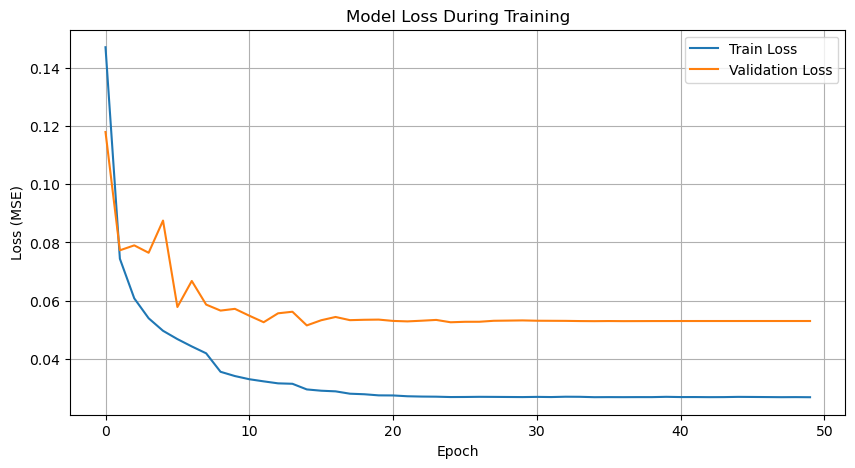

In [10]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
plt.rcParams['font.family']='Malgun Gothic'

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
from tensorflow.keras.models import load_model
loaded_model_32 = load_model('best_model_batchsize_32.h5')
loaded_model_64 = load_model('best_model_batchsize_64.h5')
loaded_model_128 = load_model('best_model_batchsize_128.h5')
loaded_model_256 = load_model('best_model_batchsize_256.h5')

# 검증셋에 대해 예측 수행
pred_scaled_32 = loaded_model_32.predict(val_gen)
pred_scaled_64 = loaded_model_64.predict(val_gen)
pred_scaled_128 = loaded_model_128.predict(val_gen)
pred_scaled_256 = loaded_model_256.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred_32 = ss.inverse_transform(pred_scaled_32)
pred_64 = ss.inverse_transform(pred_scaled_64)
pred_128 = ss.inverse_transform(pred_scaled_128)
pred_256 = ss.inverse_transform(pred_scaled_256)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

In [21]:
# 평가 지표 계산
rmse_32 = mean_squared_error(true, pred_32, squared=False)  # RMSE
r2_32 = r2_score(true, pred_32)                             # R² Score
rmse_64 = mean_squared_error(true, pred_64, squared=False)  # RMSE
r2_64 = r2_score(true, pred_64)                             # R² Score
rmse_128 = mean_squared_error(true, pred_128, squared=False)  # RMSE
r2_128 = r2_score(true, pred_128)                             # R² Score
rmse_256 = mean_squared_error(true, pred_256, squared=False)  # RMSE
r2_256 = r2_score(true, pred_256)                             # R² Score

# 결과 출력
print('✅batch size = 32')
print(f" 검증 RMSE: {rmse_32:.4f}")
print(f" R² Score: {r2_32:.4f}")
print()
print('✅batch size = 64')
print(f" 검증 RMSE: {rmse_64:.4f}")
print(f" R² Score: {r2_64:.4f}")
print()
print('✅batch size = 128')
print(f" 검증 RMSE: {rmse_128:.4f}")
print(f" R² Score: {r2_128:.4f}")
print()
print('✅batch size = 256')
print(f" 검증 RMSE: {rmse_256:.4f}")
print(f" R² Score: {r2_256:.4f}")

✅batch size = 32
 검증 RMSE: 4.0428
 R² Score: 0.9709

✅batch size = 64
 검증 RMSE: 4.6141
 R² Score: 0.9620

✅batch size = 128
 검증 RMSE: 4.8596
 R² Score: 0.9579

✅batch size = 256
 검증 RMSE: 4.6932
 R² Score: 0.9607


Epoch 23: val_loss improved from 0.03989 to 0.03952, saving model to best_model_batchsize_32.h5  
Epoch 15: val_loss improved from 0.05258 to 0.05148, saving model to best_model_batchsize_64.h5  
Epoch 19: val_loss improved from 0.05784 to 0.05711, saving model to best_model_batchsize_128.h5  
Epoch 29: val_loss improved from 0.05363 to 0.05326, saving model to best_model_batchsize_256.h5

In [ ]:
# ✅ 🔍 예측 vs 실제 시각화 ---------------------------------------------------------

df_pred = df1.iloc[split_index + sequence_length:].copy()
df_pred['predicted_congestion'] = pred
df_pred['true_congestion'] = true

df_pred[['시간', 'true_congestion', 'predicted_congestion']].set_index('시간').plot(figsize=(15, 5))
plt.title('혼잡도 예측 vs 실제')
plt.grid(True)
plt.show()


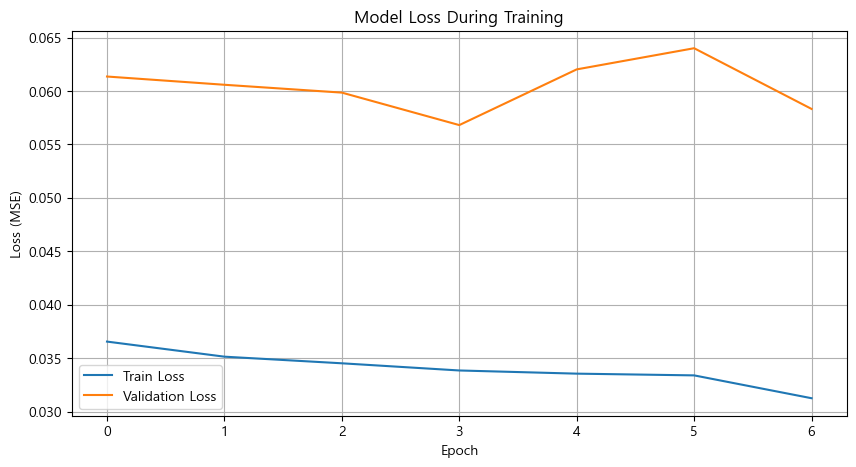

In [17]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_additional.history['loss'], label='Train Loss')
plt.plot(history_additional.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

- 6번 더 학습하니 살짝 개선
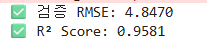
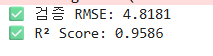

In [19]:
# 추가 학습: 이어서 계속 학습
# epochs=16~30까지 추가로 학습하려면 epochs=16을 지정하면 됩니다.
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
    initial_epoch=21,         # 14번째까지 학습했다면 여기서 이어서 시작
    callbacks=[early_stop, reduce_lr]
)

Epoch 22/30
11680/11680 [==============================] - 504s 43ms/step - loss: 0.0320 - val_loss: 0.0583 - lr: 2.5000e-04
Epoch 23/30
11680/11680 [==============================] - 511s 44ms/step - loss: 0.0317 - val_loss: 0.0583 - lr: 2.5000e-04
Epoch 24/30
11680/11680 [==============================] - 576s 49ms/step - loss: 0.0313 - val_loss: 0.0598 - lr: 2.5000e-04
Epoch 25/30
11680/11680 [==============================] - 484s 41ms/step - loss: 0.0304 - val_loss: 0.0582 - lr: 1.2500e-04
Epoch 26/30
11680/11680 [==============================] - 541s 46ms/step - loss: 0.0303 - val_loss: 0.0561 - lr: 1.2500e-04
Epoch 27/30
11680/11680 [==============================] - 517s 44ms/step - loss: 0.0301 - val_loss: 0.0570 - lr: 1.2500e-04
Epoch 28/30
11680/11680 [==============================] - 525s 45ms/step - loss: 0.0300 - val_loss: 0.0583 - lr: 1.2500e-04
Epoch 29/30
11680/11680 [==============================] - 502s 43ms/step - loss: 0.0297 - val_loss: 0.0580 - lr: 6.2500e-05


2920/2920 [==============================] - 57s 19ms/step


C:\Users\campus4D035\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ 검증 RMSE: 4.8181
✅ R² Score: 0.9586


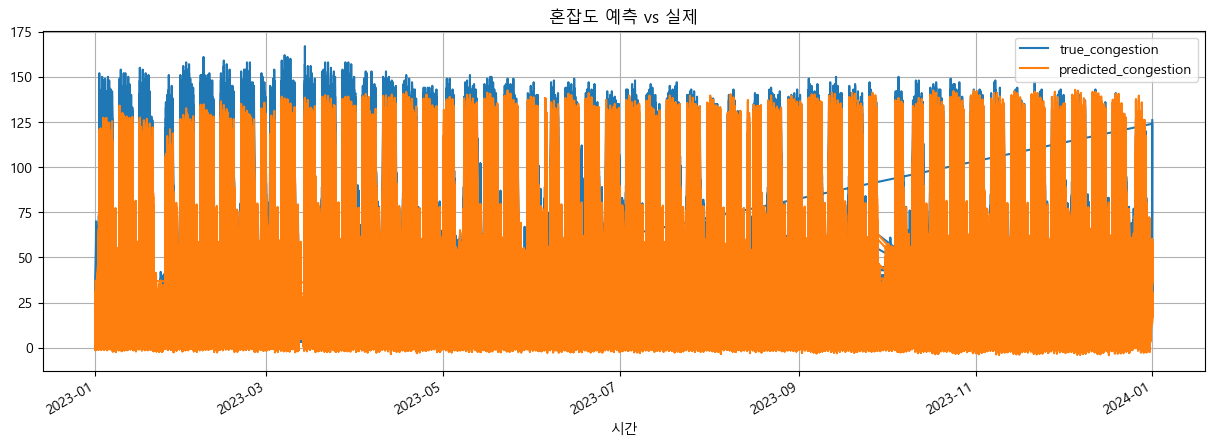

In [20]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------

# 검증셋에 대해 예측 수행
pred_scaled = model.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
rmse = mean_squared_error(true, pred, squared=False)  # RMSE
r2 = r2_score(true, pred)                             # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# ✅ 🔍 예측 vs 실제 시각화 ---------------------------------------------------------

df_pred = df1.iloc[split_index + sequence_length:].copy()
df_pred['predicted_congestion'] = pred
df_pred['true_congestion'] = true

df_pred[['시간', 'true_congestion', 'predicted_congestion']].set_index('시간').plot(figsize=(15, 5))
plt.title('혼잡도 예측 vs 실제')
plt.grid(True)
plt.show()

In [16]:
# 추가 학습: 이어서 계속 학습
# epochs=16~30까지 추가로 학습하려면 epochs=16을 지정하면 됩니다.
history_additional = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                 # 총 학습 epoch. 이미 14번 했으므로 여기선 15~30까지 실행됨
    initial_epoch=14,         # 14번째까지 학습했다면 여기서 이어서 시작
    callbacks=[
        #early_stop, 
        reduce_lr,checkpoint]
)

Epoch 15/30
11680/11680 [==============================] - 418s 36ms/step - loss: 0.0365 - val_loss: 0.0614 - lr: 5.0000e-04
Epoch 16/30
11680/11680 [==============================] - 507s 43ms/step - loss: 0.0351 - val_loss: 0.0606 - lr: 5.0000e-04
Epoch 17/30
11680/11680 [==============================] - 539s 46ms/step - loss: 0.0345 - val_loss: 0.0598 - lr: 5.0000e-04
Epoch 18/30
11680/11680 [==============================] - 526s 45ms/step - loss: 0.0338 - val_loss: 0.0568 - lr: 5.0000e-04
Epoch 19/30
11680/11680 [==============================] - 575s 49ms/step - loss: 0.0335 - val_loss: 0.0620 - lr: 5.0000e-04
Epoch 20/30
11680/11680 [==============================] - 557s 48ms/step - loss: 0.0334 - val_loss: 0.0640 - lr: 5.0000e-04
Epoch 21/30
11680/11680 [==============================] - 582s 50ms/step - loss: 0.0312 - val_loss: 0.0583 - lr: 2.5000e-04
